<a href="https://colab.research.google.com/github/liadekel/analyzing-big-data/blob/master/HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework Assignment 8

**Question 1:** Select a book or a movie's subtitle, and find the locations that appear in the book/movie. Then, draw these locations on a map (at least 10 locations) (30pt). Connect the discovered locations with lines according to their order of appearance
in the book. For example, if location B appeared immediately after location A, then draw a line connecting locations A and B (20pt).

In [9]:
!pip install turicreate
!pip install spaCy
!pip install pymongo
!pip install geopandas
!pip install descartes
!pip install geopy
!pip install folium
!pip install imageio
!pip install dnspython

# Run this to make cartopy work with colab 
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip install --no-binary shapely shapely --force
!pip install afinn
!pip install nltk
!pip install plotly_express

!python -m spacy download en_core_web_lg # Important! you need to restart runtime after install

     |████████████████████████████████| 91.9MB 56kB/s 
     |████████████████████████████████| 86.3MB 122kB/s 
     |████████████████████████████████| 3.4MB 37.6MB/s 
     |████████████████████████████████| 327kB 48.8MB/s 
     |████████████████████████████████| 3.8MB 39.8MB/s 
     |████████████████████████████████| 450kB 44.1MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320850 sha256=180b6d590114572494897643e35727034789f293abb0c76ef99f6546fa5adb23
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=7e1574f4c8b71d64f0dd76507710007544706998fdaa8bb291ffea2c5b17172b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built resampy gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  F

In [2]:
#setting up Kaggle & TuriCreate package s
import json
import os

!mkdir /root/.kaggle/
# Installing the Kaggle package

#Important Note: 
# complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"liaddekel","key":"bf0297555b2915c6c31a8f6579de9483"}

# creating kaggle.json file with the personal API-Key details 
# You can also put this file on your Google Drive

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [3]:
#!mkdir ./datasets
!mkdir ./datasets/tarantino
# download the dataset from Kaggle and unzip it
!kaggle datasets download aadityanaik/shakespeareworks -p ./datasets/tarantino
!unzip ./datasets/tarantino/*.zip  -d ./datasets/tarantino
! ls -l ./datasets/tarantino/

mkdir: cannot create directory ‘./datasets/tarantino’: File exists
shakespeareworks.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./datasets/tarantino/shakespeareworks.zip
replace ./datasets/tarantino/django_unchained_script.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./datasets/tarantino/inglorious_basterds_script.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./datasets/tarantino/pulp_fiction_script.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./datasets/tarantino/pulp_fiction_script.txt  
  inflating: ./datasets/tarantino/reservoir_dogs_screenplay.txt  
  inflating: ./datasets/tarantino/tarantino_scripts.txt  
total 1840
-rw-r--r-- 1 root root 218966 Oct  3  2019 django_unchained_script.txt
-rw-r--r-- 1 root root 199581 Oct  3  2019 inglorious_basterds_script.txt
-rw-r--r-- 1 root root 154775 Oct  3  2019 pulp_fiction_script.txt
-rw-r--r-- 1 root root 102365 Oct  3  2019 reservoir_dogs_screenplay.txt
-rw-

In [12]:
import spacy
nlp = spacy.load('en_core_web_lg')

dogs_path = './datasets/tarantino/reservoir_dogs_screenplay.txt'

def get_entites_dict_from_text(text):
    entities_dict= {}
    #using spaCy to get entities
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        e = entity.text.lower()
        if  label not in entities_dict:
            entities_dict[label] = {}
        if e not in entities_dict[label]:
            entities_dict[label][e] = 0
        entities_dict[label][e] += 1
    return entities_dict

dogs_txt = open(dogs_path,"r", encoding="utf8", errors="ignore").read()
e  = get_entites_dict_from_text(dogs_txt)
locations = list(e['GPE'])
locations

['greenbay',
 'china',
 'coon',
 'georgia',
 'the\nfuck outta',
 'costa rica',
 'nice',
 'p.o.',
 'long\nbeach',
 'vegas',
 'hamburg',
 'chicago',
 'holdaway',
 'gardena',
 'outta town',
 'wisconsin',
 'milwaukee',
 'portland',
 'los angeles',
 'santa cruz',
 'v.o.',
 'los angeles county\n',
 'los angeles county',
 'l.a.',
 'sacramento',
 'jodie',
 'gibraltar',
 'ladora heights',
 'beverly hills',
 'ladora heights\n',
 'palos verdes',
 'brooklyn',
 'poland',
 'st. petersburg',
 'b.g.']

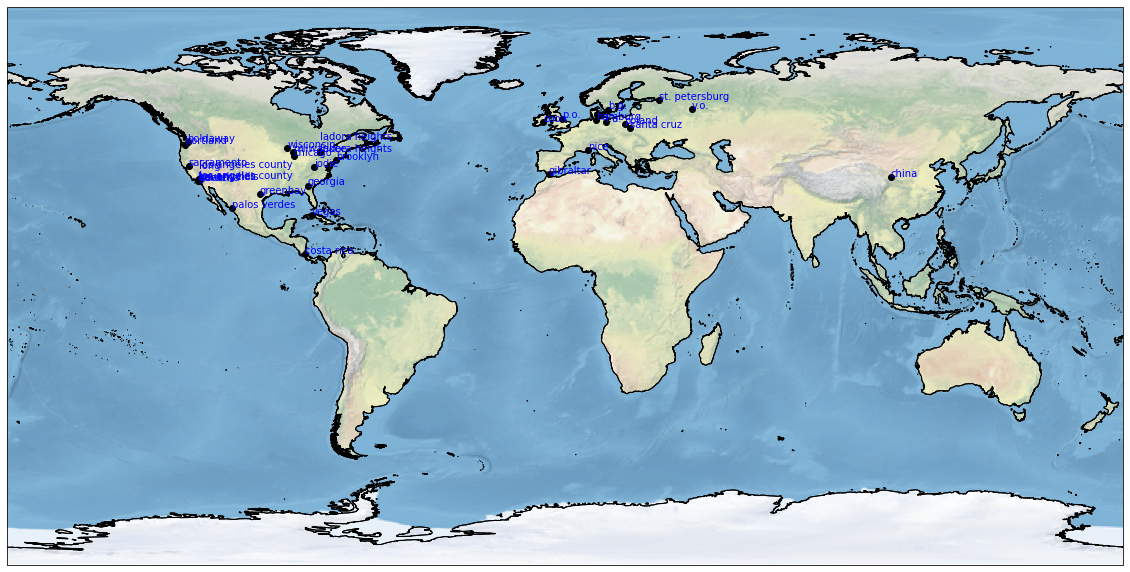

In [29]:
from geopy import Nominatim
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

geolocator = Nominatim()

plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.coastlines(resolution='10m', color='black', linewidth=1) # draw with batter coaslines resolution
ax.stock_img() # add colors 

for l in locations:
    location = geolocator.geocode(l)
    if location:
        lon, lat, name =  location.longitude, location.latitude, l
        plt.plot(lon, lat,
            color='black', marker='o', markersize=6,transform=ccrs.PlateCarree(),
            )
        ax.text(lon, lat+0.2, name, fontsize=10, color="blue", transform=ccrs.PlateCarree(),)

ax.coastlines(resolution='10m', color='black', linewidth=1) # draw with batter coaslines resolution




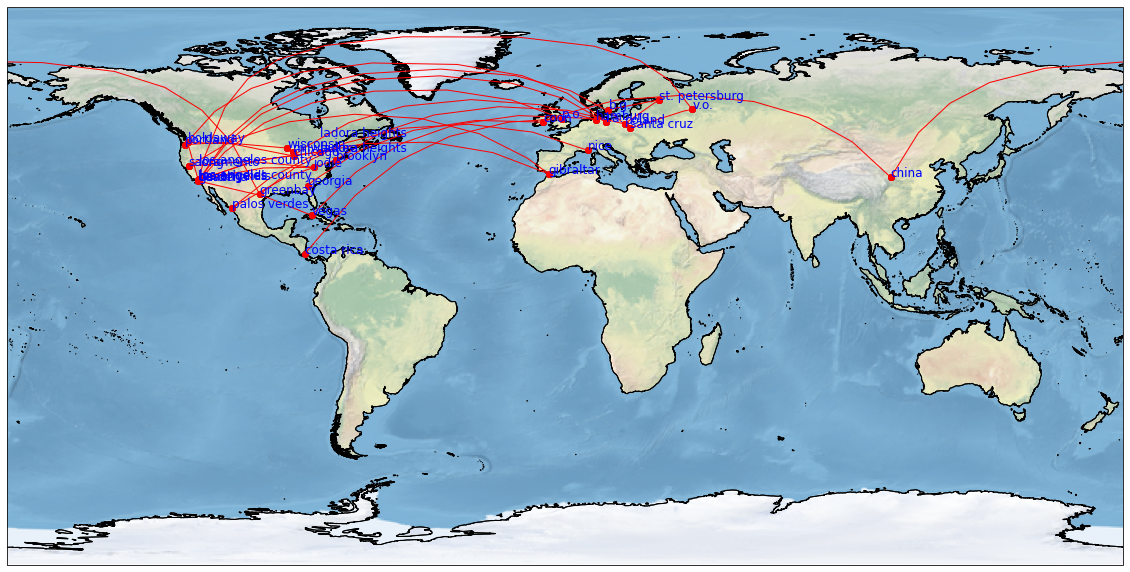

In [48]:
# find index of appearence for each location:

geolocator = Nominatim()

plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.coastlines(resolution='10m', color='black', linewidth=1) # draw with batter coaslines resolution
ax.stock_img() # add colors 

for l in locations:
    location = geolocator.geocode(l)
    if location:
        lon, lat, name =  location.longitude, location.latitude, l
        plt.plot(lon, lat,
            color='black', marker='o', markersize=6,transform=ccrs.PlateCarree(),
            )
        ax.text(lon, lat+0.2, name, fontsize=12, color="blue", transform=ccrs.PlateCarree(),)

ax.coastlines(resolution='10m', color='black', linewidth=1) # draw with batter coaslines resolution

# we will determine the order of apperance by the index
# of first occurence of each location
location_index = {}
for l in locations:
    try:
        location_index[l] = dogs_txt.lower().index(l)
    except:
        pass
location_index

import operator
# sort by index of substring
sorted_locations = list(sorted(location_index.items(), key=operator.itemgetter(1)))

# draw lines by each two following items
for i in range(len(sorted_locations) - 1):
    a = geolocator.geocode(sorted_locations[i][0])
    b = geolocator.geocode(sorted_locations[i+1][0])

    if a and b:
        plt.plot([a.longitude, b.longitude], [a.latitude, b.latitude],
            color='red', linewidth=1, marker='o',
            transform=ccrs.Geodetic(),
            )

**Question 2:** Select a country's' statistic from the [World Development Indicators dataset](https://www.kaggle.com/worldbank/world-development-indicators) (Please notice there are several files in the dataset, such as _Indicators.csv_).
Then, create a choropleth map displaying how the selected statistics changed over time (15pt) 
    
**Bonus:** Create a short animation that displays how the chosen statistics changed over time (15pt)

**Question 3:** Select a request type from [San Francisco 311 dataset](https://www.kaggle.com/datasf/case-data-from-san-francisco-311).
Create an interactive map that somehow presents in which areas this request occurs the most (35pt).